In [204]:
import pandas as pd
import numpy as np
import pickle
import itertools
from collections import OrderedDict
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv('gasNetworkData.csv', sep=';')
df.columns

Index(['valve_1', 'valve_2', 'valve_3', 'valve_4', 'valve_5', 'valve_6',
       'valve_7', 'valve_8', 'valve_9', 'valve_10', 'valve_11', 'valve_12',
       'QGRS_1', 'QGRS_2', 'QPlant_1', 'QPlant_2', 'QPlant_3', 'QPlant_4',
       'PGRS_1', 'PGRS_2', 'P_1', 'P_2', 'P_3', 'P_4', 'P_5', 'P_6', 'P_7',
       'P_8', 'P_9', 'Q_1', 'Q_2', 'Q_3', 'Q_4', 'Q_5', 'Q_6', 'Q_7'],
      dtype='object')

In [3]:
for i in range(df.shape[0]):
    df.iloc[i] = df.iloc[i].str.replace(',', '.')
df = df.astype('float')

In [4]:
data = np.asarray(df.values, dtype=np.float_)
u, s, v = np.linalg.svd(data)

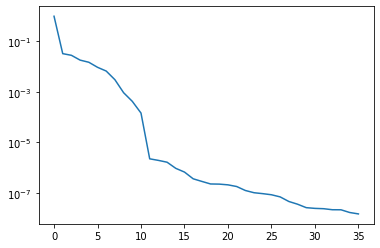

In [5]:
plt.plot(s/s[0])
plt.yscale('log')

In [6]:
# all_pq_cols = \
#     'P_1,P_2,P_3,P_4,P_7,P_8,P_9,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,QGRS_1,QGRS_2,QPlant_1,QPlant_2,QPlant_3,QPlant_4,PGRS_1,PGRS_2'
# all_pq_cols = all_pq_cols.split(',')
all_pq_cols = ['QGRS_1', 'QGRS_2', 'QPlant_1', 'QPlant_2', 'QPlant_3', 'QPlant_4',
               'PGRS_1', 'PGRS_2', 'P_1', 'P_2', 'P_3', 'P_4', 'P_5', 'P_6', 'P_7',
               'P_8', 'P_9', 'Q_1', 'Q_2', 'Q_3', 'Q_4', 'Q_5', 'Q_6', 'Q_7']
valves = ['valve_1', 'valve_2', 'valve_3', 'valve_4', 'valve_5', 'valve_6',
           'valve_7', 'valve_8', 'valve_9', 'valve_10', 'valve_11', 'valve_12']

### Predict P1

In [7]:
cols_for_p1 = ['valve_5', 'valve_2', 'valve_12', 'valve_1', 'valve_6']
data_p1 = df[cols_for_p1]
X = data_p1.values
y = df['P_1']

In [8]:
lin_reg = LinearRegression()
cv_result = cross_validate(lin_reg, X, y, scoring='r2', cv=10)
metrics = cv_result['test_score']
print(metrics.mean(), '±', metrics.std())

0.9221422326120026 ± 0.01355398703705371


In [9]:
rf = RandomForestRegressor(n_estimators=50, max_depth=10)
cv_result = cross_validate(rf, X, y, scoring='r2', cv=10, n_jobs=10)
metrics = cv_result['test_score']
print(metrics.mean(), '±', metrics.std())

0.9529226640618841 ± 0.00583511126965094


### Predict valve 3

In [10]:
# cols_for_v3 = ['P_8', 'Q_7', 'P_7']
cols_for_v3 = all_pq_cols
data_v3 = df[cols_for_v3]
X = data_v3.values
y = df['valve_3']

In [11]:
lin_reg = LinearRegression()
cv_result = cross_validate(lin_reg, X, y, scoring='r2', cv=10)
metrics = cv_result['test_score']
print(metrics.mean(), '±', metrics.std())

0.9057647888869551 ± 0.013947469930775558


In [13]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10)
cv_result = cross_validate(rf, X, y, scoring='r2', cv=10)
metrics = cv_result['test_score']
print(metrics.mean(), '±', metrics.std())

0.9682547728674409 ± 0.002720340773023703


### Predict all valves

In [97]:
data_pq = df[all_pq_cols]
X = data_pq.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
valves = ['valve_1', 'valve_2', 'valve_3', 'valve_4', 'valve_5', 'valve_6',
       'valve_7', 'valve_8', 'valve_9', 'valve_10', 'valve_11', 'valve_12']
valve_results = {}
for valve in valves:
    lin_reg = LinearRegression()
    lr_res = cross_validate(lin_reg, X_scaled, df[valve], scoring='r2', cv=10, n_jobs=-1)['test_score']
    rf = AdaBoostRegressor(n_estimators=100)
    rf_res = cross_validate(rf, X, df[valve], scoring='r2', cv=10, n_jobs=-1)['test_score']
    valve_results[valve] = f'lr - {lr_res.mean():.4f} ± {lr_res.std():.4f} ; rf - {rf_res.mean():.4f} ± {rf_res.std():.4f}'
    print(f'{valve}: lr - {lr_res.mean():.4f} ± {lr_res.std():.4f} ; rf - {rf_res.mean():.4f} ± {rf_res.std():.4f}')
    

valve_1: lr - 0.9939 ± 0.0011 ; rf - 0.9861 ± 0.0039
valve_2: lr - 0.9945 ± 0.0007 ; rf - 0.9868 ± 0.0038
valve_3: lr - 0.9058 ± 0.0139 ; rf - 0.5198 ± 0.1917
valve_4: lr - 0.4852 ± 0.0907 ; rf - -0.0516 ± 0.1613
valve_5: lr - 0.9407 ± 0.0119 ; rf - 0.7033 ± 0.0954
valve_6: lr - 0.4455 ± 0.3109 ; rf - -0.0126 ± 0.2237
valve_7: lr - 0.4474 ± 0.1539 ; rf - 0.0982 ± 0.1893
valve_8: lr - 0.3160 ± 0.0627 ; rf - 0.0207 ± 0.1200
valve_9: lr - 0.6232 ± 0.0604 ; rf - 0.5057 ± 0.0667
valve_10: lr - 0.9194 ± 0.0089 ; rf - 0.8141 ± 0.0519
valve_11: lr - 0.9511 ± 0.0056 ; rf - 0.9046 ± 0.0262
valve_12: lr - 0.8716 ± 0.0581 ; rf - 0.7756 ± 0.1053


#### Testing with additional data

In [74]:
df_add = pd.read_csv('additionalData.csv', sep=';')
for i in range(df_add.shape[0]):
    df_add.iloc[i] = df_add.iloc[i].str.replace(',', '.')
df_add = df_add.astype('float')
all_pq_cols_add = ['QGRS_1', 'QGRS_2', 'QPlant_1', 'QPlant_2', 'QPlant_3', 'QPlant_4',
                   'PGRS_1', 'PGRS_2', 'P_1', 'P_2', 'P_3', 'P_4', 'P_5', 'P_6', 'P_7',
                   'P_8', 'P_9', 'Q_1', 'Q_2', 'Q_3', 'Q_4', 'Q_5', 'Q_6', 'Q_7', 'Q_8']

In [99]:
data_pq = df_add[all_pq_cols_add]
X = data_pq.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
valves = ['valve_1', 'valve_2', 'valve_3', 'valve_4', 'valve_5', 'valve_6',
       'valve_7', 'valve_8', 'valve_9', 'valve_10', 'valve_11', 'valve_12']
valve_results = {}
for valve in valves:
    lin_reg = LinearRegression()
    lr_res = cross_validate(lin_reg, X_scaled, df_add[valve], scoring='r2', cv=10, n_jobs=-1)['test_score']
    rf = RandomForestRegressor(n_estimators=50, max_depth=12)
    rf_res = cross_validate(rf, X, df_add[valve], scoring='r2', cv=10, n_jobs=-1)['test_score']
    valve_results[valve] = f'lr - {lr_res.mean():.4f} ± {lr_res.std():.4f} ; rf - {rf_res.mean():.4f} ± {rf_res.std():.4f}'
    print(f'{valve}: lr - {lr_res.mean():.4f} ± {lr_res.std():.4f} ; rf - {rf_res.mean():.4f} ± {rf_res.std():.4f}')
    

valve_1: lr - 0.9950 ± 0.0009 ; rf - 0.9986 ± 0.0001
valve_2: lr - 0.9954 ± 0.0005 ; rf - 0.9990 ± 0.0002
valve_3: lr - 0.9217 ± 0.0083 ; rf - 0.9088 ± 0.0141
valve_4: lr - 0.6124 ± 0.0415 ; rf - 0.3697 ± 0.0524
valve_5: lr - 0.9458 ± 0.0085 ; rf - 0.9477 ± 0.0068
valve_6: lr - 0.5831 ± 0.0438 ; rf - 0.2643 ± 0.0436
valve_7: lr - 0.6454 ± 0.0423 ; rf - 0.2821 ± 0.0643
valve_8: lr - 0.6083 ± 0.0528 ; rf - 0.1176 ± 0.0844
valve_9: lr - 0.6221 ± 0.0351 ; rf - 0.6253 ± 0.0715
valve_10: lr - 0.9445 ± 0.0093 ; rf - 0.9625 ± 0.0100
valve_11: lr - 0.9644 ± 0.0060 ; rf - 0.9796 ± 0.0052
valve_12: lr - 0.8594 ± 0.0242 ; rf - 0.9554 ± 0.0171


### Predict all P and Q

Based on valve values only:

In [95]:
df_pq = df[all_pq_cols]
X = df[valves].values
pq_results = {}
for device in df_pq.columns:
    lin_reg = LinearRegression()
    lr_res = cross_validate(lin_reg, X, df_pq[device], scoring='r2', cv=10, n_jobs=-1, return_estimator=True)
    
    rf = RandomForestRegressor(n_estimators=50, max_depth=10)
    rf_res = cross_validate(rf, X, df_pq[device], scoring='r2', cv=10, n_jobs=-1, return_estimator=True)
    
    if rf_res['test_score'].mean() > lr_res['test_score'].mean():
        best_model = rf_res['estimator'][np.argmax(rf_res['test_score'])]
    else:
        best_model = lr_res['estimator'][np.argmax(lr_res['test_score'])]
    pq_results[device] = best_model
    print(f'{device}: lr - {lr_res["test_score"].mean():.4f} ± {lr_res["test_score"].std():.4f} ;'\
          f'rf - {rf_res["test_score"].mean():.4f} ± {rf_res["test_score"].std():.4f}')
    

QGRS_1: lr - 0.9876 ± 0.0015 ;rf - 0.9980 ± 0.0007
QGRS_2: lr - 0.9893 ± 0.0016 ;rf - 0.9977 ± 0.0008
QPlant_1: lr - 0.8884 ± 0.0335 ;rf - 0.9408 ± 0.0084
QPlant_2: lr - 0.9483 ± 0.0168 ;rf - 0.9641 ± 0.0068
QPlant_3: lr - 0.9639 ± 0.0119 ;rf - 0.9753 ± 0.0030
QPlant_4: lr - 0.9184 ± 0.0314 ;rf - 0.9841 ± 0.0017
PGRS_1: lr - 0.9845 ± 0.0020 ;rf - 0.9849 ± 0.0033
PGRS_2: lr - 0.9819 ± 0.0015 ;rf - 0.9801 ± 0.0051
P_1: lr - 0.9469 ± 0.0104 ;rf - 0.9622 ± 0.0038
P_2: lr - 0.9404 ± 0.0051 ;rf - 0.9258 ± 0.0114
P_3: lr - 0.9142 ± 0.0135 ;rf - 0.9195 ± 0.0143
P_4: lr - 0.9297 ± 0.0062 ;rf - 0.9346 ± 0.0126
P_5: lr - 0.9452 ± 0.0063 ;rf - 0.9431 ± 0.0135
P_6: lr - 0.9502 ± 0.0056 ;rf - 0.9430 ± 0.0144
P_7: lr - 0.9586 ± 0.0073 ;rf - 0.9602 ± 0.0137
P_8: lr - 0.9567 ± 0.0091 ;rf - 0.9587 ± 0.0114
P_9: lr - 0.9555 ± 0.0074 ;rf - 0.9728 ± 0.0047
Q_1: lr - 0.9425 ± 0.0057 ;rf - 0.9569 ± 0.0050
Q_2: lr - 0.8849 ± 0.0240 ;rf - 0.9036 ± 0.0203
Q_3: lr - 0.8845 ± 0.0330 ;rf - 0.8802 ± 0.0211
Q_4: lr 

Based on valves and GRS P and Q values, since they are predicted very well:

In [20]:
df_pq = df[all_pq_cols]
X = df[valves].values
X_grs = df[[*valves,  'PGRS_1', 'PGRS_2', 'QGRS_1', 'QGRS_2']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pq_grs_results = {}
for device in df_pq.columns:
    lin_reg = LinearRegression()
    lr_res = cross_validate(lin_reg, X_scaled, df_pq[device], scoring='r2', cv=10, n_jobs=-1, return_estimator=True)
    
    rf = RandomForestRegressor(n_estimators=50, max_depth=10)
    rf_res = cross_validate(rf, X, df_pq[device], scoring='r2', cv=10, n_jobs=-1, return_estimator=True)
    
    if rf_res['test_score'].mean() > lr_res['test_score'].mean():
        best_model = rf_res['estimator'][np.argmax(rf_res['test_score'])]
        bm_name = 'Random Forest'
    else:
        best_model = lr_res['estimator'][np.argmax(lr_res['test_score'])]
        bm_name = 'Linear Regression'
        
    pq_grs_results[device] = best_model
    print(f'{device:9s}lr - {lr_res["test_score"].mean():.4f} ± {lr_res["test_score"].std():.4f} ; '\
          f'rf - {rf_res["test_score"].mean():.4f} ± {rf_res["test_score"].std():.4f} ; '\
          f'{bm_name}')
    

QGRS_1   lr - 1.0000 ± 0.0000 ; rf - 1.0000 ± 0.0000 ; Linear Regression
QGRS_2   lr - 1.0000 ± 0.0000 ; rf - 1.0000 ± 0.0000 ; Linear Regression
QPlant_1 lr - 0.8919 ± 0.0340 ; rf - 0.9720 ± 0.0043 ; Random Forest
QPlant_2 lr - 0.9490 ± 0.0161 ; rf - 0.9838 ± 0.0024 ; Random Forest
QPlant_3 lr - 0.9641 ± 0.0114 ; rf - 0.9889 ± 0.0012 ; Random Forest
QPlant_4 lr - 0.9661 ± 0.0098 ; rf - 0.9960 ± 0.0004 ; Random Forest
PGRS_1   lr - 1.0000 ± 0.0000 ; rf - 1.0000 ± 0.0000 ; Linear Regression
PGRS_2   lr - 1.0000 ± 0.0000 ; rf - 1.0000 ± 0.0000 ; Linear Regression
P_1      lr - 0.9527 ± 0.0069 ; rf - 0.9906 ± 0.0009 ; Random Forest
P_2      lr - 0.9645 ± 0.0029 ; rf - 0.9653 ± 0.0072 ; Random Forest
P_3      lr - 0.9559 ± 0.0077 ; rf - 0.9557 ± 0.0098 ; Linear Regression
P_4      lr - 0.9673 ± 0.0025 ; rf - 0.9677 ± 0.0076 ; Random Forest
P_5      lr - 0.9762 ± 0.0024 ; rf - 0.9724 ± 0.0079 ; Linear Regression
P_6      lr - 0.9789 ± 0.0019 ; rf - 0.9713 ± 0.0090 ; Linear Regression
P_7   

In [28]:
for device, model in pq_grs_results.items():
    pickle.dump(model, open(os.path.join('models', f'{device}_model.sav'), 'wb'))

### Test heuristics

In [96]:
models = pq_results

In [103]:
X = df[valves].values
heur_data = {
    'QGRS': np.zeros(len(df), dtype=np.float32),
    'QPrivate': np.zeros(len(df), dtype=np.float32),
    'QPlant': np.zeros(len(df), dtype=np.float32),
            }
for name, model in models.items():
    preds = model.predict(X)
    if name.startswith('QGRS'):
        heur_data['QGRS'] += preds
    elif name.startswith('Q_'):
        heur_data['QPrivate'] += preds
    elif name.startswith('QPlant'):
        heur_data['QPlant'] += preds

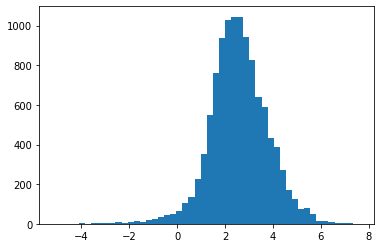

In [106]:
difference = heur_data['QGRS'] - heur_data['QPrivate'] - heur_data['QPlant']
_ = plt.hist(difference, bins=50)

In [109]:
difference

array([3.3474426, 1.1966553, 3.8134995, ..., 2.5928478, 2.8594704,
       1.8619347], dtype=float32)

### Physical model of gas flow

In [259]:
import pickle
import os
from scipy.optimize import root

class GasNCity():
    def __init__(self, load_models=False, folder_path = ''):
        self.qp_cols = ['QGRS_1', 'QGRS_2', 'QPlant_1', 'QPlant_2', 'QPlant_3', 'QPlant_4',
                        'PGRS_1', 'PGRS_2', 'P_1', 'P_2', 'P_3', 'P_4', 'P_5', 'P_6', 'P_7',
                        'P_8', 'P_9', 'Q_1', 'Q_2', 'Q_3', 'Q_4', 'Q_5', 'Q_6', 'Q_7']
        self.qp_models = {}
        self.valves = ['valve_1', 'valve_2', 'valve_3', 'valve_4', 'valve_5', 'valve_6',
                       'valve_7', 'valve_8', 'valve_9', 'valve_10', 'valve_11', 'valve_12']
        self.good_valves = ['valve_1', 'valve_2', 'valve_3', 
                            'valve_5', 'valve_10', 'valve_11', 'valve_12']
        self.valve_models = {}
        if load_models:
            for device in self.qp_cols:
                path = os.path.join(folder_path, f'{device}_model.sav')
                self.qp_models[device] = pickle.load(open(path, 'rb'))
            for valve in self.good_valves:
                path = os.path.join(folder_path, f'{valve}_model.sav')
                self.valve_models[valve] = pickle.load(open(path, 'rb'))
    
    def predict_qp(self, valves):
        valves = pd.DataFrame(valves)
        out_data = {}
        for device, model in self.qp_models.items():
            if device.startswith('QGRS') or device.startswith('PGRS'):
                out_data[device] = model.predict(valves)
        
        df_grs = pd.DataFrame(out_data)
        valves_grs = valves.join(df_grs)
        for device, model in self.qp_models.items():
            if not device.startswith('QGRS') and not device.startswith('PGRS'):
                out_data[device] = model.predict(valves_grs)
                
        out_df = pd.DataFrame(out_data)
        return out_df
    
    def predict_good_valves(self, qps):
        pqs = pd.DataFrame(qps)
        out_valves = {}
        for valve, model in self.valve_models.items():
            out_valves[valve] = model.predict(qps.values)
        out_df = pd.DataFrame(out_valves)
        return out_df
            
    
    def init_models(self):
        lr_qp_devices = self.qp_cols #['P_3', 'P_5', 'P_6', 'Q_4', 'Q_5']
        rf_qp_devices = [dev for dev in self.qp_cols if dev not in lr_qp_devices]
        
        lr_v_models = ['valve_3']
        rf_v_models = ['valve_1', 'valve_2', 'valve_5', 'valve_10', 'valve_11', 'valve_12']
        for device in lr_qp_devices:
            self.qp_models[device] = LinearRegression()
        for device in rf_qp_devices:
            self.qp_models[device] = RandomForestRegressor(n_estimators=50, max_depth=10)
        for v in lr_v_models:
            self.valve_models[v] = LinearRegression()
        for v in rf_v_models:
            self.valve_models[v] = RandomForestRegressor(n_estimators=50, max_depth=10)
            
    def fit_models(self, data: pd.DataFrame, y: pd.DataFrame, verbose=False):
        '''
        data: valve values
        y: device values
        '''
        self.qp_mean = y.mean()
        self.qp_std = y.std()
        for valve, model in self.valve_models.items():
            self.valve_models[valve] = model.fit(y, data[valve])
            if verbose:
                print(f'Model for {valve} fited')
        grs_data = data.join(y[['QGRS_1', 'QGRS_2', 'PGRS_1', 'PGRS_2']])
        for device, model in self.qp_models.items():
            if device.startswith('QGRS') or device.startswith('PGRS'):
                self.qp_models[device] = model.fit(data, y[device])
            else:
                self.qp_models[device] = model.fit(grs_data, y[device])
            if verbose:
                print(f'Model for {device} fited')
    
    
    def save_models(self, folder: str = ''):
        for device, model in self.qp_models.items():
            path = os.path.join(folder, f'{device}_model.sav')
            pickle.dump(model, open(path, 'wb'))
        for device, model in self.valve_models.items():
            path = os.path.join(folder, f'{device}_model.sav')
            pickle.dump(model, open(path, 'wb'))
    
    
    def find_valves(self, qps, constraint=[], verbose=False):
        '''Optimize valve values to fit to the qp requirements'''
        valves_to_predict = [v for v in self.valves if v not in self.good_valves and v not in constraint]
        grid = OrderedDict()
        for v in sorted(valves_to_predict, key=lambda t: int(t.split('_')[-1])):
            grid[v] = np.linspace(0.1, 1, num=6, endpoint=True)
        params = OrderedDict()
        for v in sorted(self.valves, key=lambda t: int(t.split('_')[-1])):
            params[v] = []
        out = OrderedDict()
        for v in sorted(self.valves, key=lambda t: int(t.split('_')[-1])):
            out[v] = []
        
        good_valves = self.predict_good_valves(qps)
        for v in good_valves.columns:
            out[v] = good_valves[v].values
        for v in constraint:
            out[v] = np.zeros(len(qps))
        for entry, qp in enumerate(qps.values):
            rmse_data = []
            best_rmse = np.inf
            best_combo = {}
            for guess in tqdm(itertools.product(*grid.values())):
                for v in good_valves.columns:
                    params[v] = [good_valves[v][entry]]

                for i, v in enumerate(grid.keys()):
                    params[v] = [guess[i]]
                
                qp_pred = (self.predict_qp(pd.DataFrame(params)) - self.qp_mean) / self.qp_std
                qp_scaled = (qp - self.qp_mean) / self.qp_std
                rmse = np.sum(((qp_pred - qp_scaled)**2 / (qp_scaled+1e-6)**2).values)
                rmse_data.append(rmse)
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_combo = params
            for v in valves_to_predict:
                out[v].append(best_combo[v][0])
            if verbose:
                print(f'Solution found for {entry}-th entry')
            plt.plot(rmse_data)
        return pd.DataFrame(out)

    
    def plant_q_rule(self, series, threshold=1e-1):
        return (series >= threshold).astype(int)


    def private_q_rule(self, series, threshold=0.6):
        name = series.name
        if name in ['Q_1', 'Q_7']:
            threshold *= 2
        if name in ['Q_6']:
            threshold *= 4
        return (series >= threshold).astype(int)


    def get_q_by_p(self, pressure):
        if pressure.name in ['P_1', 'P_8']:
            return -0.3 + pressure * 7 / 1e6

        elif pressure.name in ['P_2', 'P_3', 'P_4', 'P_6']:
            return -0.2 + pressure * 4 / 1e6


    def validate_plant(self, preds):
        res = self.plant_q_rule(preds)
        return res


    def validate_private(self, preds):
        res = self.private_q_rule(preds)
        return res


    def check_distribution(self, preds):
        pass


    def check_pressure_order(self, idx, preds):
        determined_pairs = [
            ('P_9', 'P_8'),
            ('P_7', 'P_8'),
            ('P_7', 'P_6'),
            ('P_7', 'P_5'),
            ('P_4', 'P_3'),
            ('P_6', 'P_3'),
            ('P_6', 'P_2'),
        ]

        most_probable_pairs = [
            ('P_9', 'P_1'),
            ('P_7', 'P_4'),
        ]

        for pair in determined_pairs:
            if preds[pair[0]] < preds[pair[1]]:
                print(f"WARNING in row {idx}: There's no such case in the dataset: "
                      f"{pair[1]} is greater than {pair[0]}. Please check your predictions")

        for pair in most_probable_pairs:
            if preds[pair[0]] < preds[pair[1]]:
                print(f"WARNING in row {idx}: There are very few such case in the dataset: "
                      f"{pair[1]} is greater than {pair[0]}. Please check your predictions")
        return


    def check_p_q_relationship(self, preds):
        mapping = {
            'P_1': 'Q_1',
            'P_4': 'Q_4',
            'P_6': 'Q_5',
            'P_8': 'Q_7',
            'P_2': 'Q_2',
            'P_3': 'Q_3',
        }

        for i in range(1, 10):
            col = f'P_{i}'
            # If not checked, continue
            if col not in mapping:
                continue

            # Preprocess column
            series = preds[col]
            if i == 2:
                series /= 2
                series += preds['P_1'] / 2

            # Check the difference between predicted and original
            diff_allowed = 0.05
            if i in [2, 3]:
                diff_allowed = 0.07
            elif i in [1, 8]:
                diff_allowed = 0.1

            q_pred = self.get_q_by_p(series)
            diff = (preds[mapping[col]] - q_pred).abs()
            bad_index = diff[diff > diff_allowed].index
            if bad_index.shape[0] > 0:
                print(f'WARNING in rows {bad_index.values}: {col} does not follow {mapping[col]} relationship')


    def check_validity(self, preds):
        # Check "Q exceeds min level"
        for i in range(1, 8):
            preds[f'validPrivate_{i}'] = self.validate_private(preds[f'Q_{i}'])

        for i in range(1, 5):
            preds[f'validPlant_{i}'] = self.validate_plant(preds[f'QPlant_{i}'])

        # Check "P_9 > 200 000 for Plant 4"
        preds['validP9'] = (preds['P_9'] > 200000).astype(int)

        # Check order of Pressures
        for idx, row in preds.iterrows():
            self.check_pressure_order(idx, row)

        # Check that some specific Q and P follow their linear relationship
        self.check_p_q_relationship(preds)

        cols = [i for i in preds.columns if i.startswith('valid')]
        validity_score = preds[cols].mean(axis=1)
        validity_binary = preds[cols].product(axis=1)

        return validity_binary, validity_score


Let's test it!

In [260]:
gas = GasNCity(load_models=False, folder_path='models')
gas.init_models()
gas.fit_models(df[valves], y=df[all_pq_cols], verbose=True)
# gas = GasNCity(load_models=True, folder_path='models')

Model for valve_3 fited
Model for valve_1 fited
Model for valve_2 fited
Model for valve_5 fited
Model for valve_10 fited
Model for valve_11 fited
Model for valve_12 fited
Model for QGRS_1 fited
Model for QGRS_2 fited
Model for QPlant_1 fited
Model for QPlant_2 fited
Model for QPlant_3 fited
Model for QPlant_4 fited
Model for PGRS_1 fited
Model for PGRS_2 fited
Model for P_1 fited
Model for P_2 fited
Model for P_3 fited
Model for P_4 fited
Model for P_5 fited
Model for P_6 fited
Model for P_7 fited
Model for P_8 fited
Model for P_9 fited
Model for Q_1 fited
Model for Q_2 fited
Model for Q_3 fited
Model for Q_4 fited
Model for Q_5 fited
Model for Q_6 fited
Model for Q_7 fited


In [261]:
gas.save_models('models')

7776it [03:42, 34.96it/s]

Solution found for 0-th entry


,valve_1,valve_2,valve_3,valve_4,valve_5,valve_6,valve_7,valve_8,valve_9,valve_10,valve_11,valve_12
0,0.860689,0.443507,0.306254,1.0,0.723737,1.0,1.0,1.0,1.0,0.327774,0.773479,0.998259


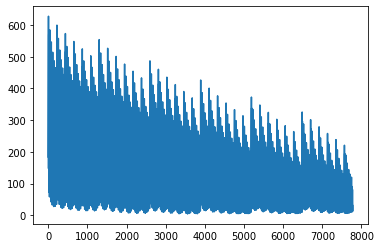

In [262]:
res = gas.find_valves(df[all_pq_cols][:1], verbose=True)
res

In [267]:
qps = gas.predict_qp(res)
%timeit gas.check_validity(qps)

9.14 ms ± 146 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [264]:
df[all_pq_cols][:1]

,QGRS_1,QGRS_2,QPlant_1,QPlant_2,QPlant_3,QPlant_4,PGRS_1,PGRS_2,P_1,P_2,...,P_7,P_8,P_9,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7
0,17.911733,9.257217,1.122351,2.148112,5.624864,8.07628,303535.895746,261828.526728,213391.443357,202884.784496,...,257146.643682,202885.460552,255259.392425,1.164164,0.637044,0.644746,0.658984,0.685891,2.608879,1.06969


In [240]:
qps.to_csv('val.csv')

In [182]:
a = pd.DataFrame({'a':[1,2,3]})
b = pd.DataFrame({'b':[4,5,6]})
c = a.join(b)
c, a, b

(   a  b
 0  1  4
 1  2  5
 2  3  6,
    a
 0  1
 1  2
 2  3,
    b
 0  4
 1  5
 2  6)